# Outlier detection with alabi_detect

chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://readthedocs.org/projects/alibi-detect/downloads/pdf/stable/

### Temperature example

In [1]:
import numpy as np
import pandas as pd
import matplotlib

from alibi_detect.od import SpectralResidual

<Axes: title={'center': 'Temperature fluctuations over a week in August 2023'}>

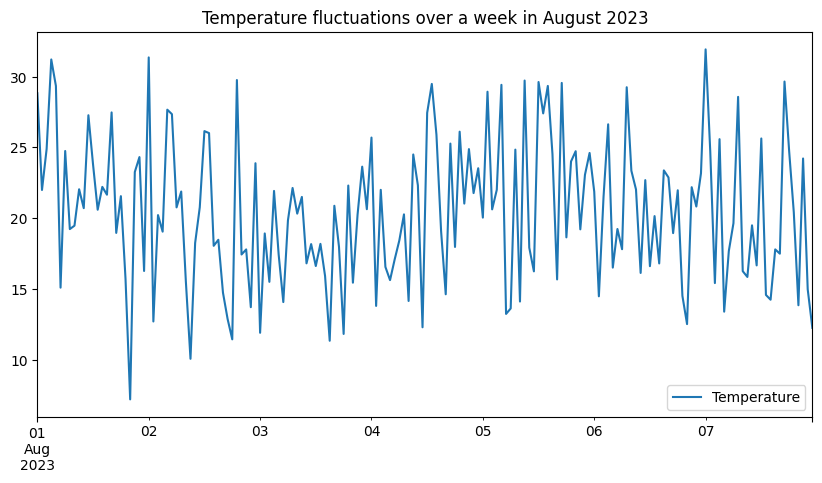

In [2]:
# Generate example temperature data for a week
np.random.seed(0)
time_steps = 7 * 24  # 7 days, 24 hours per day
normal_temps = np.random.normal(20, 5, time_steps)  # Normal temperature fluctuations

# Create a time index
time_index = pd.date_range(start='2023-08-01', periods=time_steps, freq='H')

# Convert to DataFrame
temperature_data = pd.DataFrame({'Temperature': normal_temps}, index=time_index)
temperature_data.plot(title='Temperature fluctuations over a week in August 2023', figsize=(10, 5))

In [3]:
#anomaly_temps
# Add an anomaly: sudden hot and cold temperatures for a few hours
temperature_data.loc['2023-08-03 12:00':'2023-08-03 13:00'] += 150
temperature_data.loc['2023-08-05 03:00':'2023-08-05 06:00'] -= 200

In [4]:
#outliers are
out=(100*(len(temperature_data.loc['2023-08-03 12:00':'2023-08-03 23:00'])+len(temperature_data.loc['2023-08-05 03:00':'2023-08-05 06:00']))/len(temperature_data))
th_perc = round(100-out) #threshold percent

<Axes: >

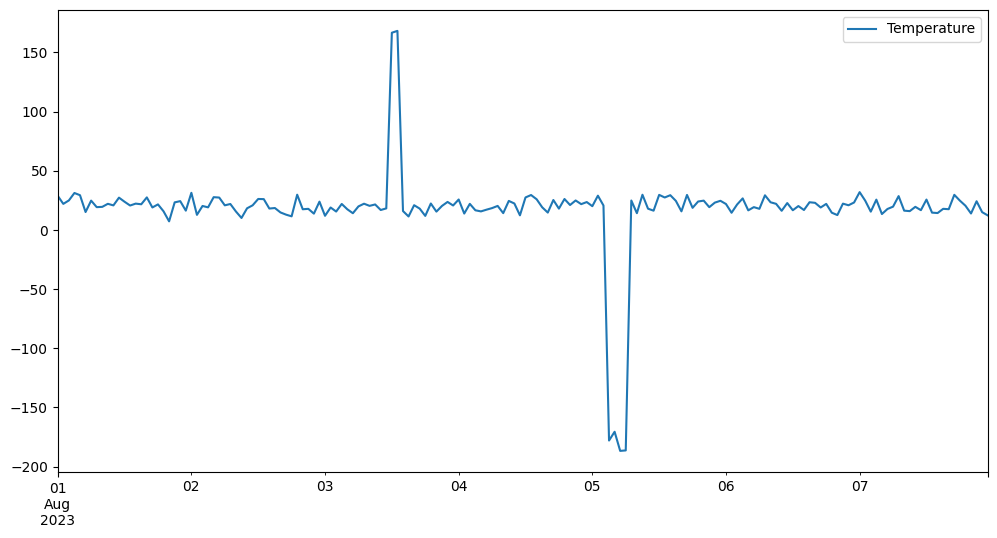

In [5]:
temperature_data.plot(figsize=(12, 6))

In [6]:
# Initialize the Spectral Residual detector

od_temp = SpectralResidual(
    threshold=None,                  # threshold for outlier score
    window_amp=20,                   # window for the average log amplitude
    window_local=20,                 # window for the average saliency map
    n_est_points=20,                 # nb of estimated points padded to the end of the sequence
    padding_amp_method='replicate',    # padding method to be used prior to each convolution over log amplitude.
    padding_local_method='replicate',  # padding method to be used prior to each convolution over saliency map.
    padding_amp_side='bilateral'     # whether to pad the amplitudes on both sides or only on one side.
)


No threshold level set. Need to infer threshold using `infer_threshold`.


In [7]:
#infer threshold 
od_temp.infer_threshold(temperature_data['Temperature'].values, threshold_perc=90)
#print('New threshold: {:.4f}'.format(od_temp.threshold))

#predicting outliers
temp_outliers = od_temp.predict(temperature_data['Temperature'].values,return_instance_score=True) #dictionary
anomaly_scores = od_temp.score(temperature_data['Temperature'].values) 

#equivalent
# temp_outliers = od_temp.predict(samples, return_instance_score=True)
# anomaly_scores = temp_outliers['data']['instance_score']
# anomaly_scores

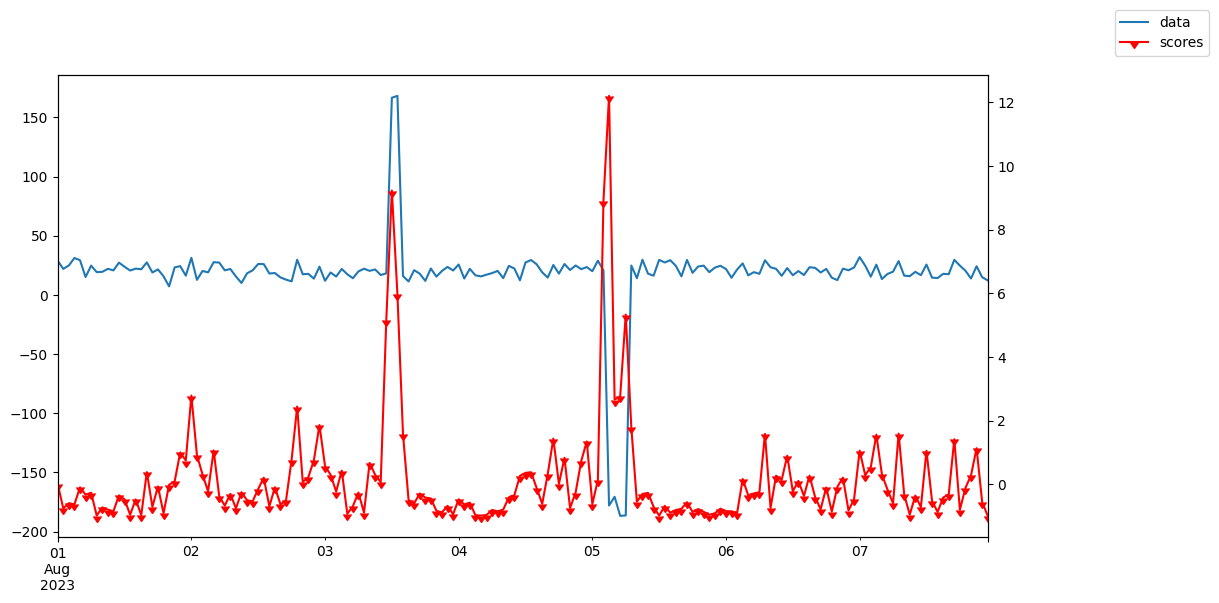

In [8]:
import matplotlib
ax = pd.Series(temperature_data['Temperature'], name="data").plot(
    legend=False, figsize=(12, 6)
)

ax2 = ax.twinx()
ax = pd.Series(anomaly_scores, index=temperature_data.index, name="scores").plot(
    ax=ax2, legend=False, color="r", marker=matplotlib.markers.CARETDOWNBASE
)
ax.figure.legend(bbox_to_anchor=(1, 1), loc="upper left")

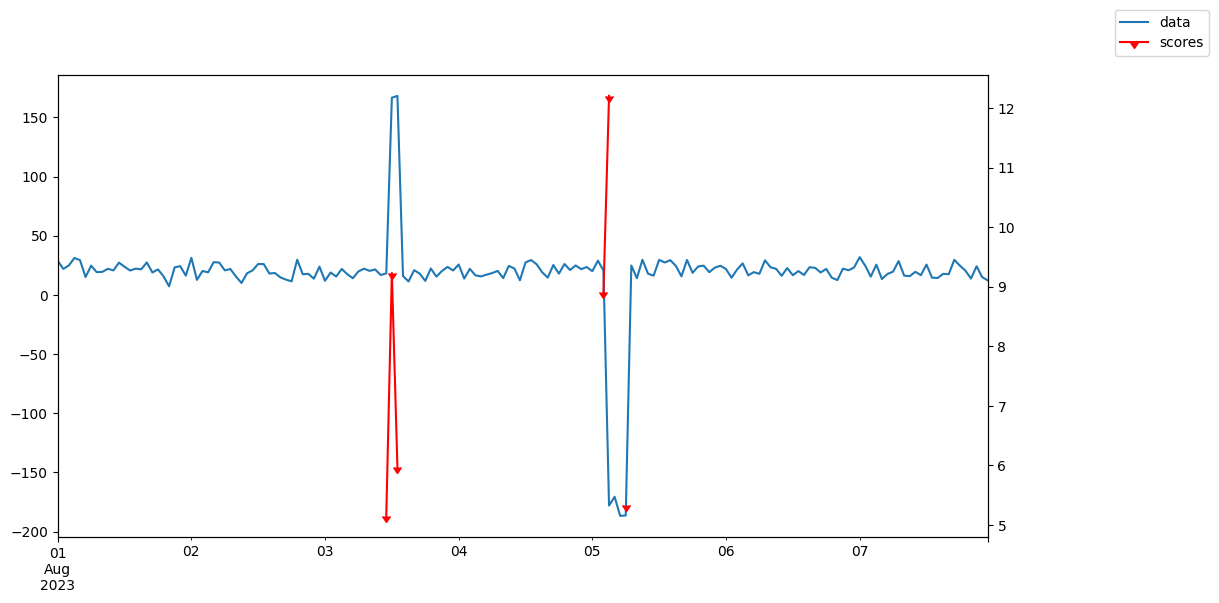

In [9]:
#print only scores for outliers
a_s_copy = anomaly_scores.copy()
for i in range(len(anomaly_scores)):
    if a_s_copy[i] < 3.0:
        a_s_copy[i] = np.nan
    else:
        a_s_copy[i] = a_s_copy[i]


import matplotlib
ax = pd.Series(temperature_data['Temperature'], name="data").plot(
    legend=False, figsize=(12, 6)
)

ax2 = ax.twinx()
ax = pd.Series(a_s_copy, index=temperature_data.index, name="scores").plot(
    ax=ax2, legend=False, color="r",marker=matplotlib.markers.CARETDOWNBASE
)
ax.figure.legend(bbox_to_anchor=(1, 1), loc="upper left")

<Axes: >

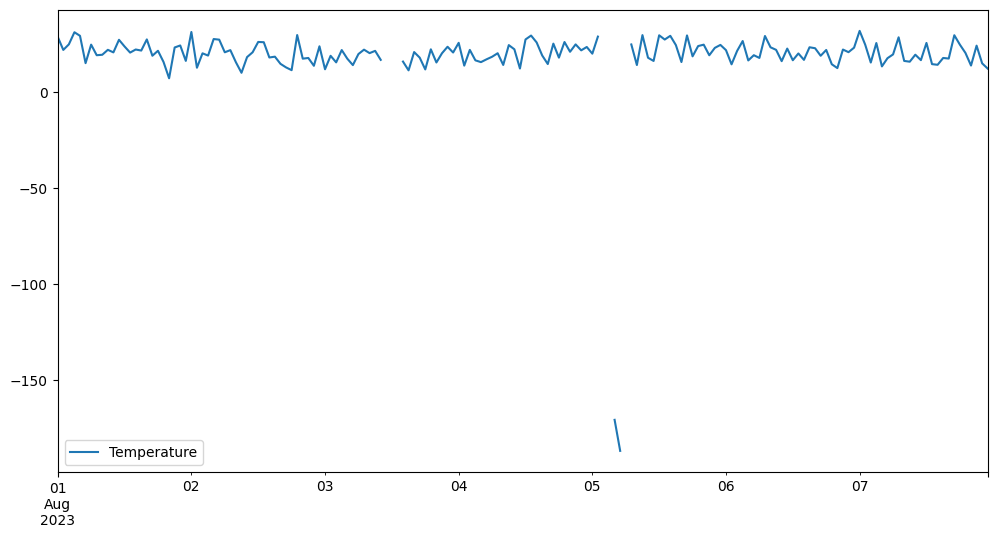

In [13]:
#remove outliers

temperature_data_c = temperature_data.copy()

for i,score in enumerate(anomaly_scores):
    if score > 3.0:
        temperature_data_c['Temperature'][i] = np.nan
    else:
        pass

temperature_data_c.plot(figsize=(12, 6))



### Documentation example 
https://docs.seldon.io/projects/alibi-detect/en/latest/examples/od_sr_synth.html

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score
import timesynth as ts

from alibi_detect.od import SpectralResidual
from alibi_detect.utils.perturbation import inject_outlier_ts
from alibi_detect.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_ts

In [ ]:
n_points = 100000
# timestamps
time_sampler = ts.TimeSampler(stop_time=n_points // 4)
time_samples = time_sampler.sample_regular_time(num_points=n_points)

# harmonic time series with Gaussian noise
sinusoid = ts.signals.Sinusoidal(frequency=0.25)
white_noise = ts.noise.GaussianNoise(std=0.1)
ts_harm = ts.TimeSeries(signal_generator=sinusoid, noise_generator=white_noise)


In [ ]:
samples, signals, errors = ts_harm.sample(time_samples)

In [ ]:
X = samples.reshape(-1, 1).astype(np.float32)


In [ ]:
data = inject_outlier_ts(X, perc_outlier=10, perc_window=10, n_std=2., min_std=1.)
X_outlier= data.data
y_outlier = data.target.astype(int)
labels = data.target_names

print(type(data),type(data.target),data.data)

In [ ]:
n_plot = 200

plt.plot(time_samples[:n_plot], X[:n_plot], marker='o', markersize=4, label='sample')
plt.plot(time_samples[:n_plot], signals[:n_plot], marker='*', markersize=4, label='signal')
plt.plot(time_samples[:n_plot], errors[:n_plot], marker='.', markersize=4, label='noise')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Original sinusoid with noise')
plt.legend()
plt.show()

In [ ]:
plt.plot(time_samples[:n_plot], X[:n_plot], marker='o', markersize=4, label='original')
plt.plot(time_samples[:n_plot], X_outlier[:n_plot], marker='*', markersize=4, label='perturbed')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Original vs. perturbed data')
plt.legend()
plt.show()

In [ ]:
od = SpectralResidual(
    threshold=None,                  # threshold for outlier score
    window_amp=20,                   # window for the average log amplitude
    window_local=20,                 # window for the average saliency map
    n_est_points=20,                 # nb of estimated points padded to the end of the sequence
    padding_amp_method='reflect',    # padding method to be used prior to each convolution over log amplitude.
    padding_local_method='reflect',  # padding method to be used prior to each convolution over saliency map.
    padding_amp_side='bilateral'     # whether to pad the amplitudes on both sides or only on one side.
)

Infer threshold, let's assume we have data and we know 10% of it is outliers

In [ ]:
X_threshold = X_outlier[:10000, :]

In [ ]:
od.infer_threshold(X_threshold, time_samples[:10000], threshold_perc=90)
print('New threshold: {:.4f}'.format(od.threshold))

In [ ]:
print(len(X_outlier),len(time_samples))

In [ ]:
od_preds = od.predict(X_outlier, return_instance_score=True) # time_samples,

In [ ]:
plot_instance_score(od_preds, y_outlier, labels, od.threshold)